# Validation of a single layer pouch cell

### Imports

In [1]:
using BattMo, GLMakie, Jutul, DataFrames, Revise

Makie.inline!(true)


SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


true

### Input parameters and settings

In [2]:
cell_parameters = load_cell_parameters(; from_default_set = "xu_2015")
cycling_protocol = load_cycling_protocol(; from_default_set = "cc_discharge")
model_settings = load_model_settings(; from_default_set = "p4d_pouch")
simulation_settings = load_simulation_settings(; from_default_set = "p4d_pouch")

cell_parameters["Cell"]["NumberOfLayers"] = 1
cell_parameters["Cell"]["TabsOnSameSide"] = true
cell_parameters["Cell"]["DoubleCoatedElectrodes"] = false
cell_parameters["NegativeElectrode"]["CurrentCollector"]["TabPositionFraction"] = 0.22
cell_parameters["PositiveElectrode"]["CurrentCollector"]["TabPositionFraction"] = 0.78

simulation_settings["ElectrodeWidthGridPoints"] = 20
simulation_settings["ElectrodeLengthGridPoints"] = 20

cycling_protocol["DRate"] = 1

1

### Setup model and simulation

In [3]:
model = LithiumIonBattery(; model_settings)

sim = Simulation(model, cell_parameters, cycling_protocol; simulation_settings);

✔️ Validation of ModelSettings passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CellParameters passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of CyclingProtocol passed: No issues found.
──────────────────────────────────────────────────
✔️ Validation of SimulationSettings passed: No issues found.
──────────────────────────────────────────────────
neg_tab_start_frac = 0.10805970149253732
neg_tab_end_frac = 0.33194029850746265
pos_tab_start_frac = 0.6680597014925374
pos_tab_end_frac = 0.8919402985074627
segment_widths = [0.007240000000000001, 0.015, 0.022520000000000005, 0.015, 0.007239999999999999]
"Δx in active region = $(cell_widths[1])" = "Δx in active region = 0.0024133333333333337"
"NE tab width = $(neg_tab_width_points) points" = "NE tab width = 3 points"
"PE tab width = $(pos_tab_width_points) points" = "PE tab width = 3 points"


### Plot geometry

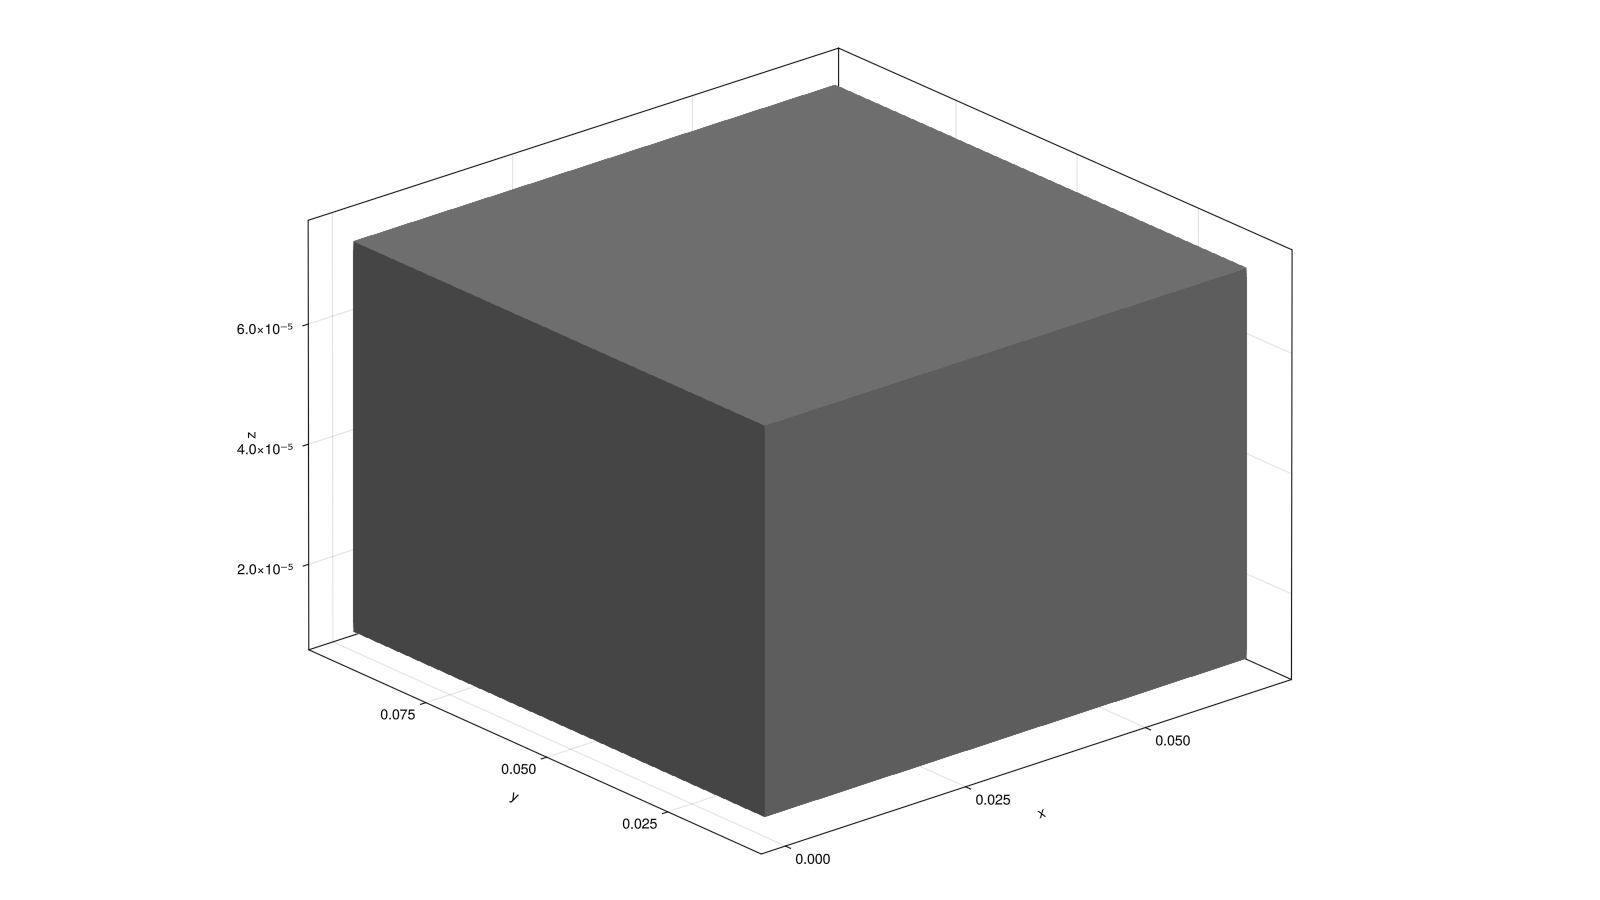

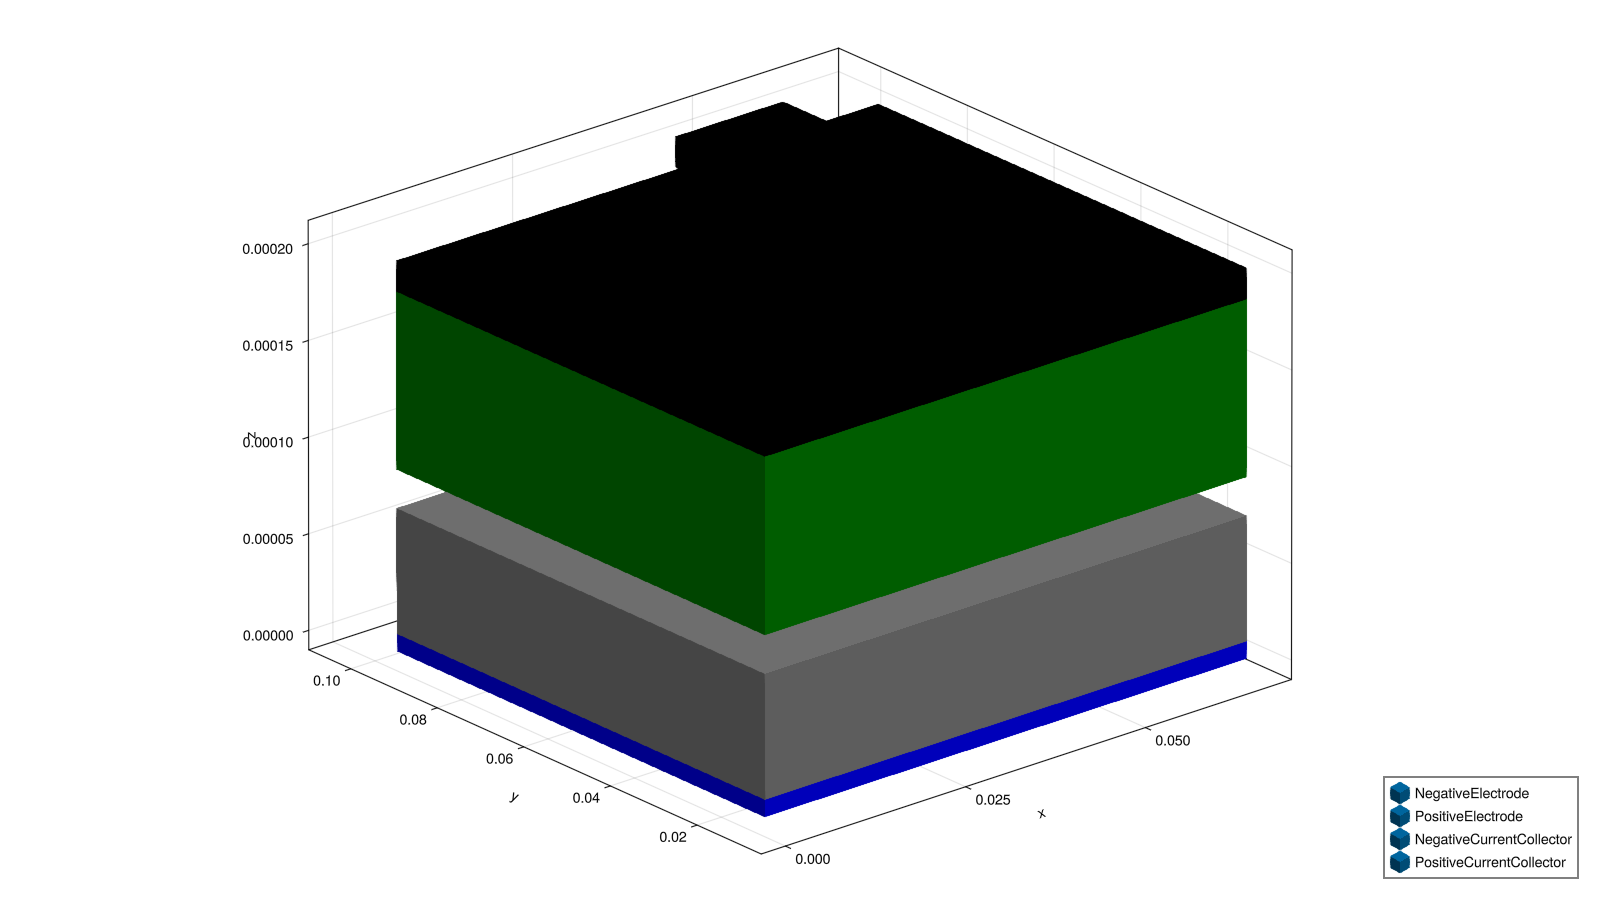

In [4]:
grids     = sim.grids
couplings = sim.couplings


components = ["NegativeElectrode", "PositiveElectrode", "NegativeCurrentCollector", "PositiveCurrentCollector"]
colors = [:gray, :green, :blue, :black]
nothing #hide

# We plot the geometry

for (i, component) in enumerate(components)
	if i == 1
		global fig, ax = plot_mesh(grids[component],
			color = colors[i],
			label = string(component))
		# ax.aspect = :data
	else
		plot_mesh!(ax,
			grids[component],
			color = colors[i],
			label = string(component))
	end
end
axislegend(ax, position = :rb)
fig

### Plot mesh

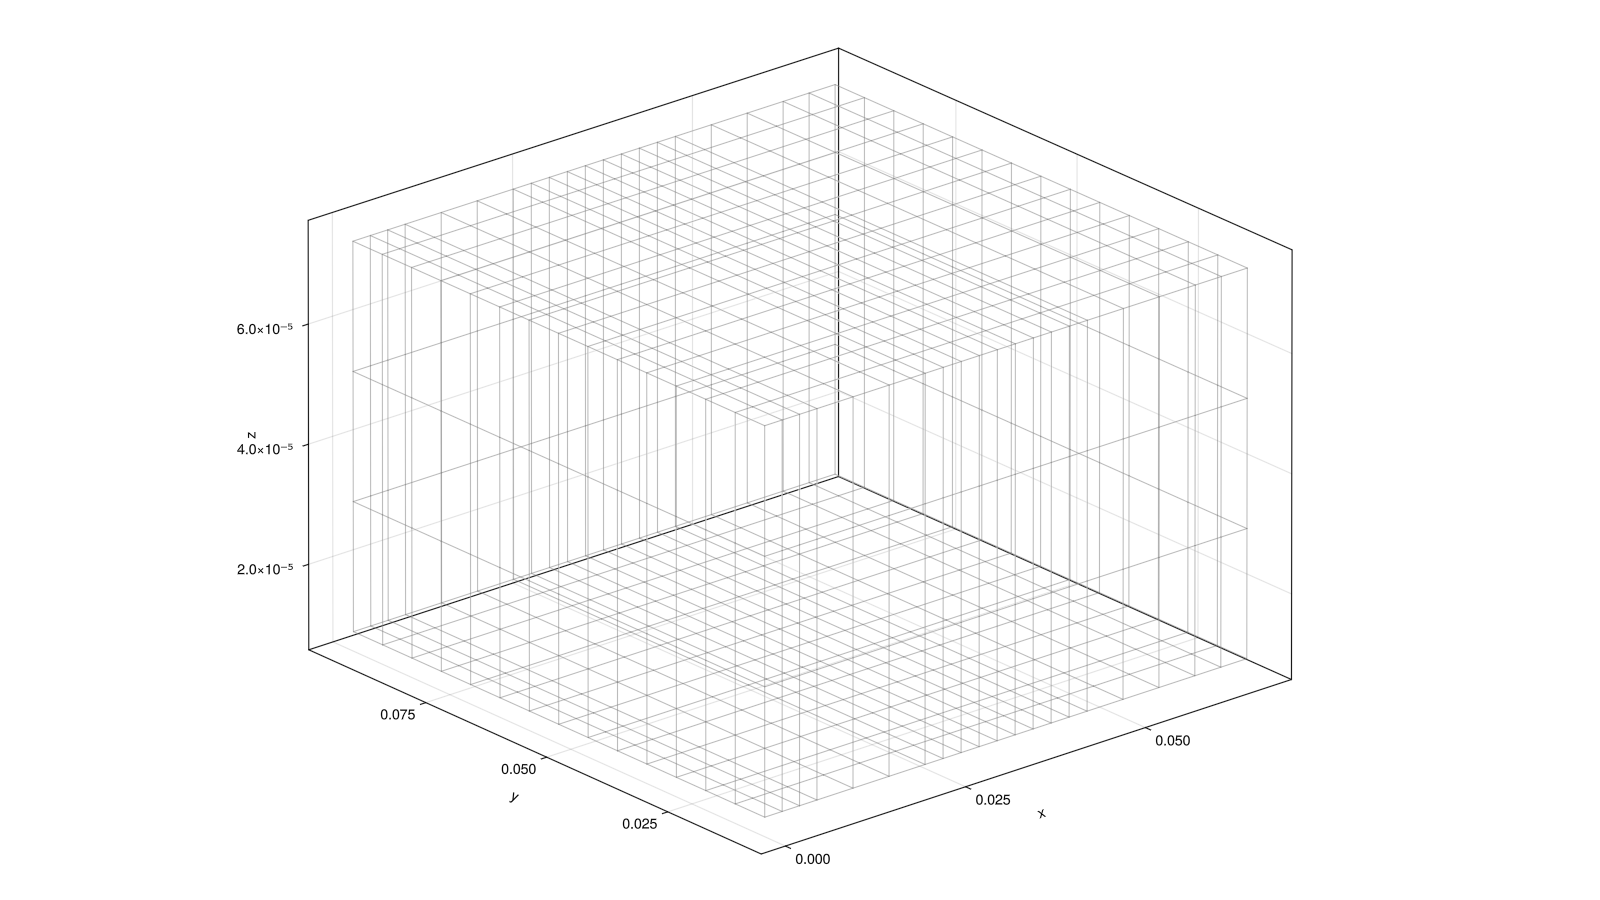

Legend()

In [5]:
for (i, component) in enumerate(components)
	if i == 1
		global fig, ax = plot_mesh_edges(grids[component],
			color = colors[i],
			label = string(component))
		ax.aspect = :data
	else
		plot_mesh_edges!(ax,
			grids[component],
			color = colors[i],
			label = string(component))
	end
    
end
legend_elements = [
	PolyElement(color = colors[i]) for i in eachindex(components)
]

Legend(fig[1, 2], legend_elements, components)

### Solve simulation

In [6]:
output = solve(sim);

✔️ Validation of SolverSettings passed: No issues found.
──────────────────────────────────────────────────
Jutul: Simulating 1 hour, 6 minutes as 84 report steps


Progress   2%|█                                          |  ETA: 0:25:57

Progress   4%|█▌                                         |  ETA: 0:24:03

Progress   5%|██                                         |  ETA: 0:26:14

Progress   6%|██▌                                        |  ETA: 0:24:38

Progress   7%|███                                        |  ETA: 0:23:35

Progress   8%|███▌                                       |  ETA: 0:22:36

Progress   9%|████                                       |  ETA: 0:21:09

Progress  11%|████▌                                      |  ETA: 0:19:58

Progress  12%|█████                                      |  ETA: 0:18:53

Progress  13%|█████▋                                     |  ETA: 0:18:01

Progress  14%|██████▏                                    |  ETA: 0:17:16

Progress  15%|██████▋                                    |  ETA: 0:16:34

Progress  16%|███████▏                                   |  ETA: 0:16:01

Progress  18%|███████▋                

╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │ 72 steps │ 72 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │  2.61111 │      2.61111 │  188 (0) │
│ Linearization  │  3.61111 │      3.61111 │  260 (0) │
│ Linear solver  │  2.61111 │      2.61111 │  188 (0) │
│ Precond apply  │      0.0 │          0.0 │    0 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬────────┬────────────┬──────────╮
│ Timing type   │   Each │   Relative │    Total │
│               │      s │ Percentage │        s │
├───────────────┼────────┼────────────┼──────────┤
│ Properties    │ 0.0576 │     1.21 % │  10.8327 │
│ Equations     │ 0.7511 │    21.81 % │ 195.2784 │
│ Assembly      │ 0.0211 │     0.61 % │   5.4932 │
│ Linear solve  │ 3.5814 │    75.19 % │ 673.2958 │
│ Linear setup  │ 0.0000 │     0.00 % │   0.0000 │
│ Precond apply │ 0.0000 │     0.00 %

### Compare results to experimental data from paper

In [7]:
# Load the experimental data
battmo_base = normpath(joinpath(pathof(BattMo) |> splitdir |> first, ".."))
exdata = joinpath(battmo_base, "examples", "example_data")
df_05 = CSV.read(joinpath(exdata, "Xu_2015_voltageCurve_05C.csv"), DataFrame)
df_1 = CSV.read(joinpath(exdata, "Xu_2015_voltageCurve_1C.csv"), DataFrame)
df_2 = CSV.read(joinpath(exdata, "Xu_2015_voltageCurve_2C.csv"), DataFrame)

dfs = [df_05, df_1, df_2]

t0 = output0.time_series["Time"]
V0 = output0.time_series["Voltage"]
t_exp_05, V_exp_05 = get_tV(df_05)
t_exp_1, V_exp_1 = get_tV(df_1)

UndefVarError: UndefVarError: `CSV` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: CSV is loaded but not imported in the active module Main.

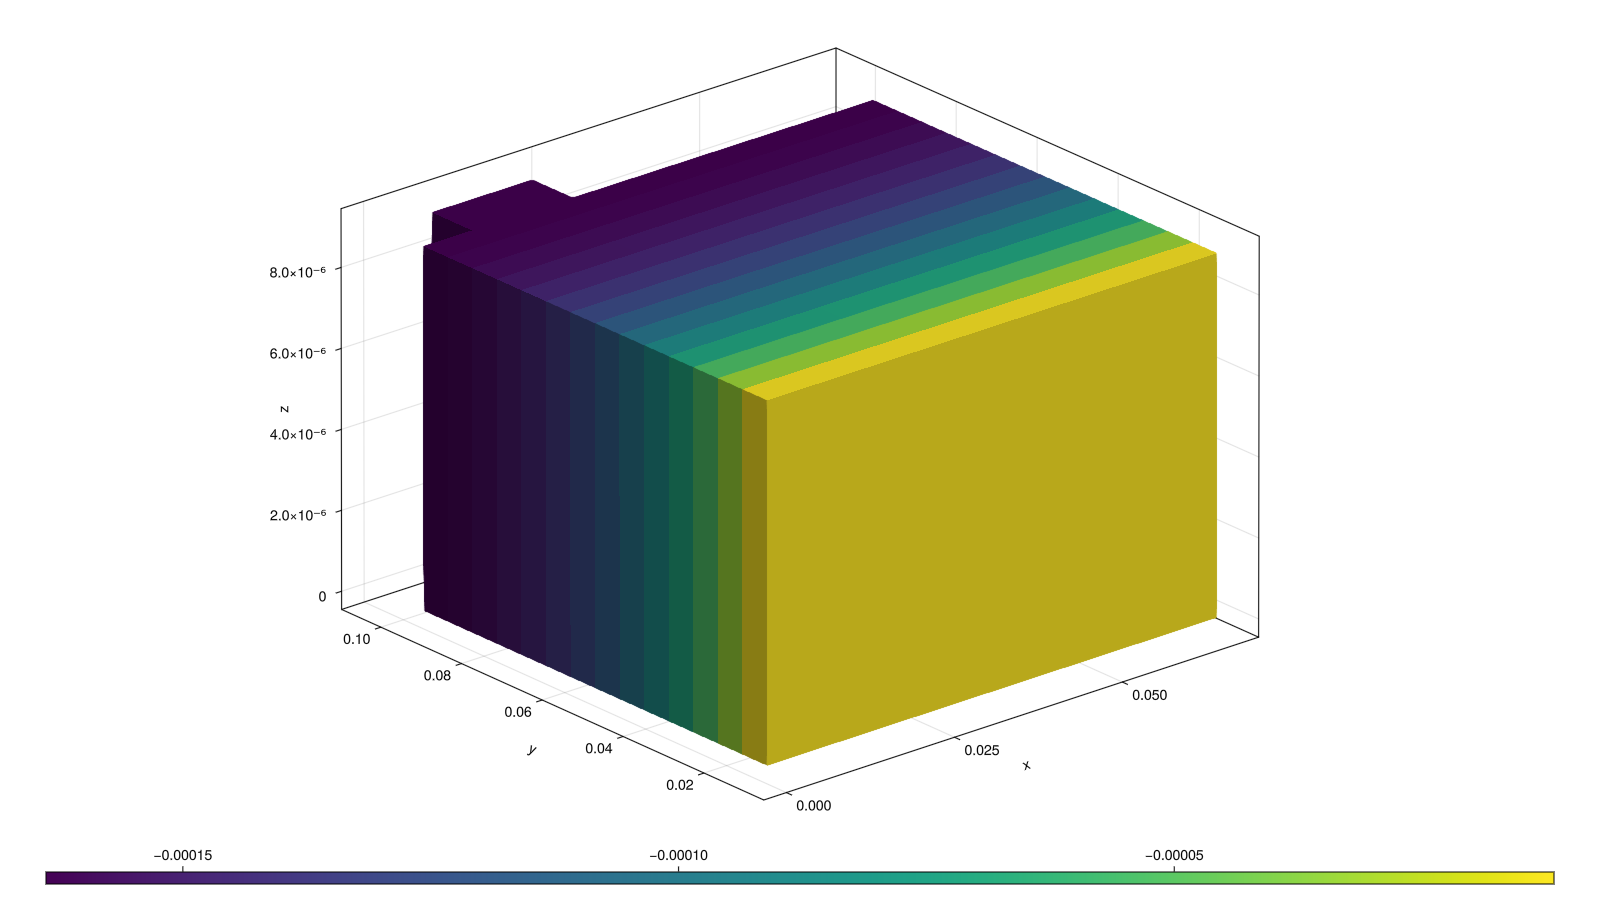

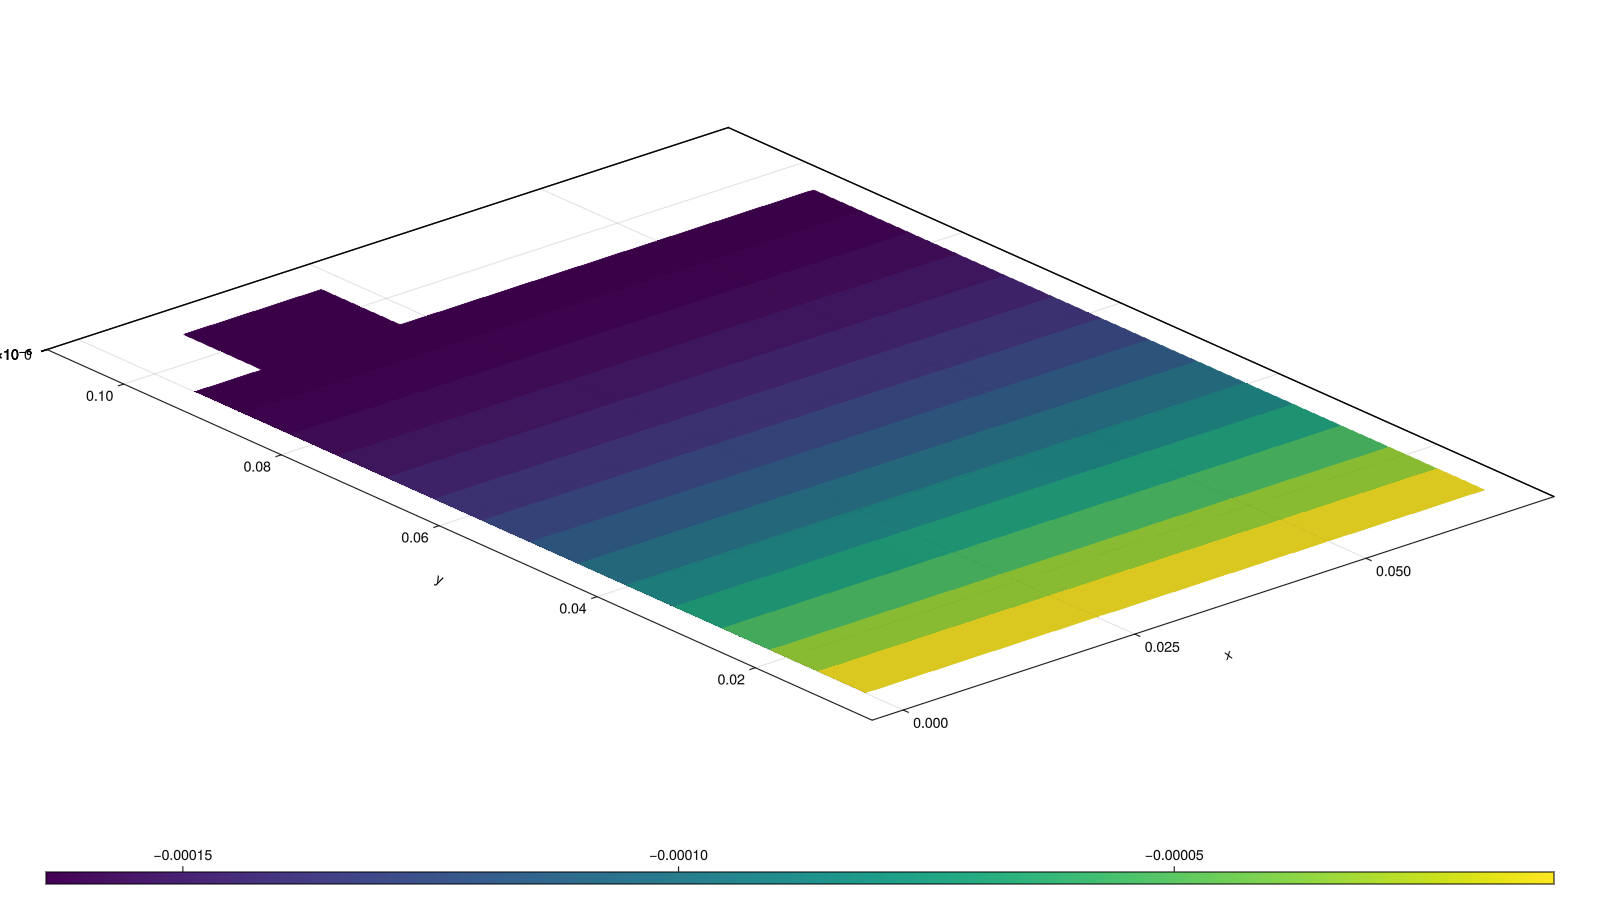

In [8]:
fig, ax = plot_cell_data(grids["NegativeCurrentCollector"], output.jutul_output.states[end][:NegativeElectrodeCurrentCollector][:ElectricPotential])
ax.aspect = :data
fig

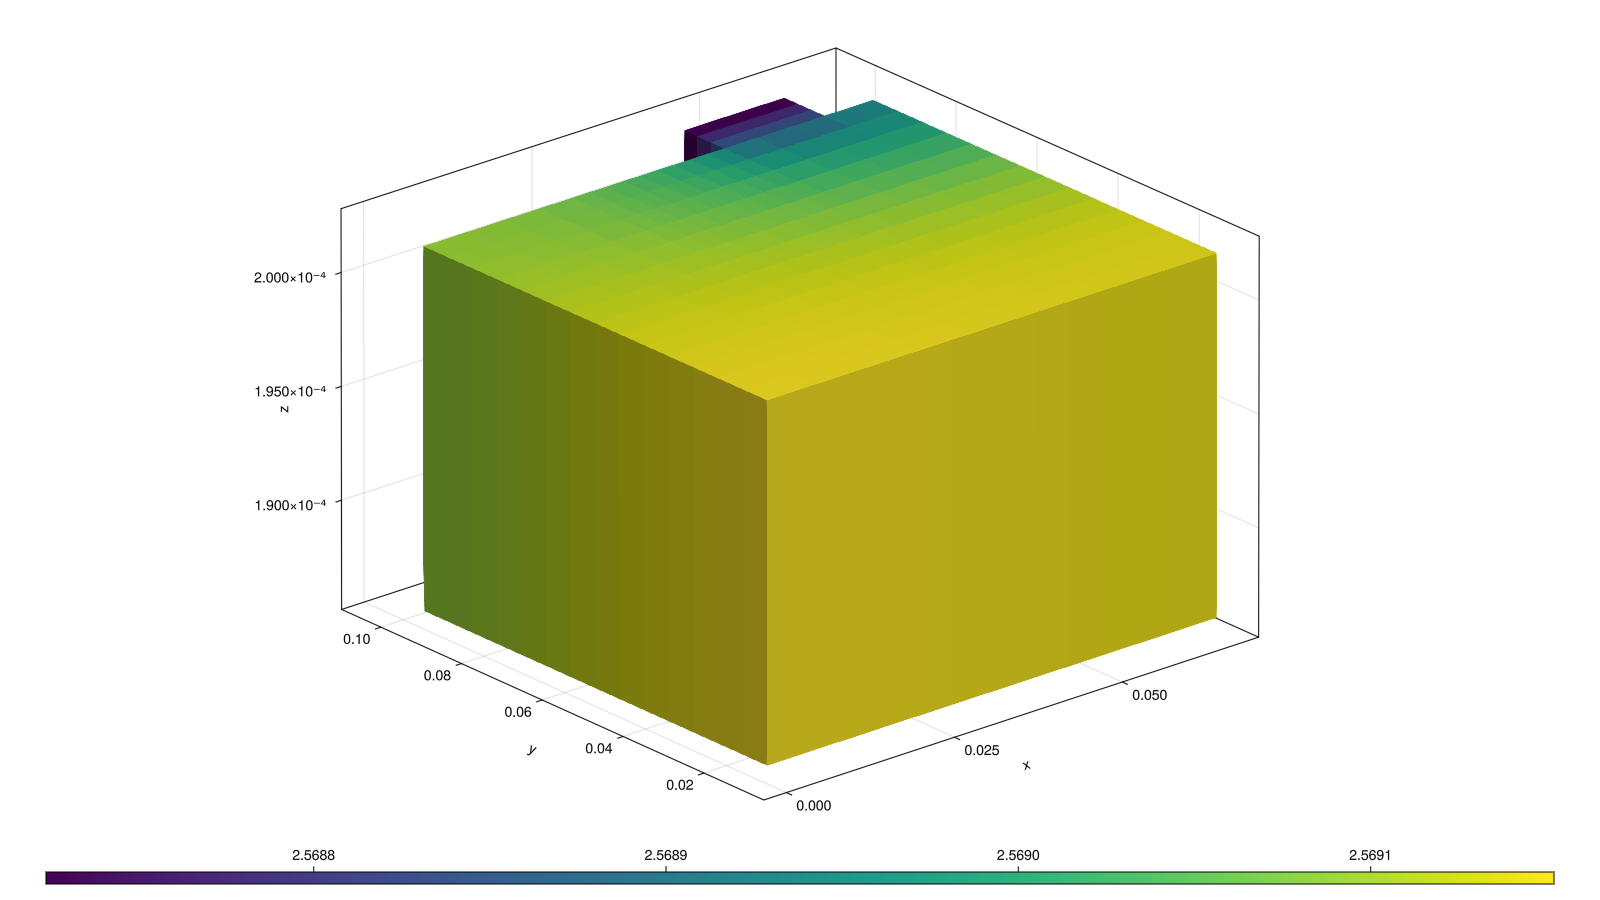

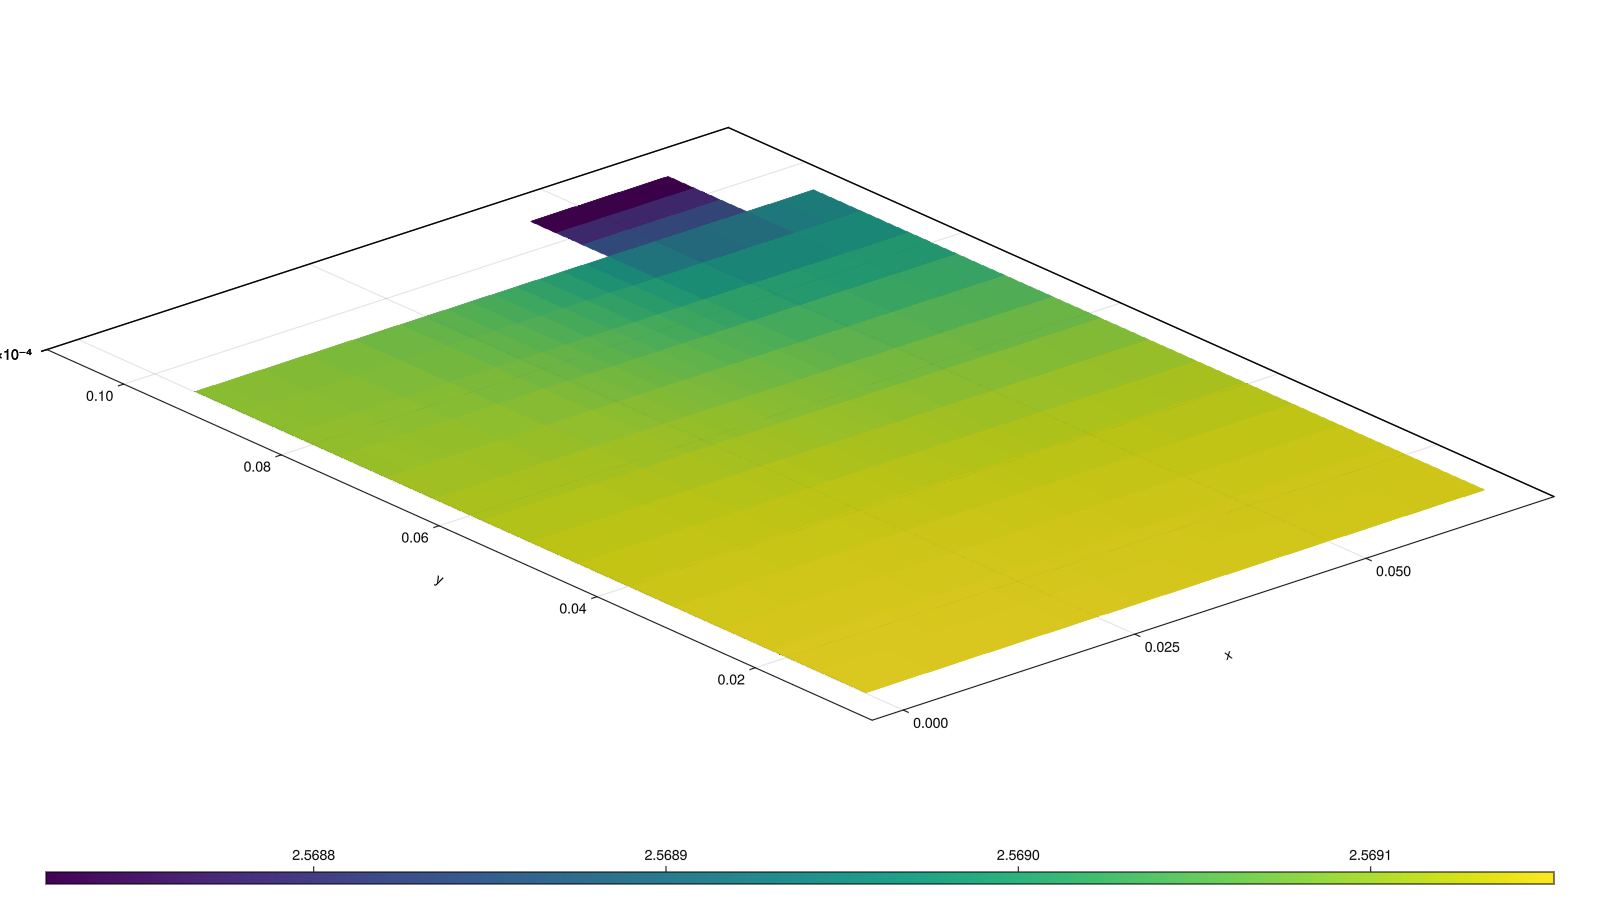

In [9]:
fig, ax = plot_cell_data(grids["PositiveCurrentCollector"], output.jutul_output.states[end][:PositiveElectrodeCurrentCollector][:ElectricPotential])
ax.aspect = :data
fig